# Expected Goals (xG)
This notebook illustrates how to train, evaluate and use a basic xG model.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Load dataset
We will use our dataset with StatsBomb events and corresponding SPADL actions of the Big 5 leagues in 2015/16. The `1.1-load-statsbomb-data` notebook explains how to create this dataset and the `1.2-convert-events-to-actions` notebook adds the SPADL representation of the events.

In [3]:
from pathlib import Path
from socceraction.data import HDFDataset, PartitionIdentifier

data_dir = Path("../../data")

# Open a HDF dataset
dataset = HDFDataset(
    path=(data_dir / "statsbomb-bigfive-1516.h5"), 
    mode="r"
)

We will train the model on the data of four leagues and use the fifth league for testing purposes.

In [4]:
train_partitions = [
    PartitionIdentifier(competition_id=2,  season_id=27),  # ENG 2015/16
    PartitionIdentifier(competition_id=7,  season_id=27),  # FRA 2015/16
    PartitionIdentifier(competition_id=9,  season_id=27),  # GER 2015/16
    PartitionIdentifier(competition_id=11, season_id=27),  # ESP 2015/16
]
test_partitions = [
    PartitionIdentifier(competition_id=12, season_id=27),  # ITA 2015/16
]

## Transform data to features and labels

Next, this data has to be converted to features and labels. You can find a list of feature generators in the `socceraction.features` module. The `socceraction.data.transforms.ActionsToFeatures` class provides a convenient interface to apply a set of feature transformers to a dataset. Here, we'll only compute the most basic set of features, which are the shot type (penalty, free kick, open play), the distance from goal, the angle towards the goal and the bodypart (foot, head or other). More details about the feature generators is given in the `1.3-generate-features` notebook.

In [5]:
from socceraction.data.transforms import ActionsToFeatures

In [6]:
from socceraction.xg import create_shot_mask

dataset_transformer = ActionsToFeatures(
    xfns=[
        "actiontype",
        "dist_shot",
        "visible_angle_shot",
        "bodypart",
        "goal_from_shot",
    ],
    mask_fn=create_shot_mask({"shot"}, exclude_owngoals=True)
)

To test the transformer, we can compute the features and labels of a single game.

In [7]:
df_features = dataset.transform(
    dataset_transformer, 
    from_table="actions", 
    to_table=None, 
    partitions=[PartitionIdentifier(competition_id=2, season_id=27, game_id=3754003)]
).set_index(["game_id", "action_id", "original_event_id"])
df_features

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


visible_angle_shot  \
game_id action_id original_event_id                                          
3754003 249       4b498665-4b53-4748-918d-69b5721e5da6            0.282149   
        543       1cb44193-2210-4305-9aed-fc88c71c17b1            0.303117   
        674       293c7e7d-ee1d-4800-8361-88cd14770f27            0.175228   
        1268      3b538926-bf9a-4541-b5af-759786e885ea            0.337161   
        1328      19121e60-0f57-4c1e-88d6-0f2c80b85fb3            0.497683   
        1342      3a167a7c-10d3-49b1-891c-e097201e8669            0.378631   
        1521      95de94c0-19aa-49e7-81b7-1e8d6cae69fc            0.626688   
        1643      43fe4a66-8628-483f-ab82-c82fa1a658aa            1.816504   
        1793      ff400da5-923a-40ba-8690-b1b60460a6ac            0.819798   
        1877      d3436ac2-abc1-47d1-955e-514058f62d56            0.281761   
        1975      b3e693fc-a35a-4364-86dc-3f494e66a330            0.249317   
        1987      dd14c230-b818-4ff8-819b-119d079d24ee            0.497448   
        2025      342de9c9-2835-47bf-a0fd-b8397a0e29f1            0.483444   

                                                        dist_shot actiontype  \
game_id action_id original_event_id                                            
3754003 249       4b498665-4b53-4748-918d-69b5721e5da6  24.585373       shot   
        543       1cb44193-2210-4305-9aed-fc88c71c17b1  23.385504       shot   
        674       293c7e7d-ee1d-4800-8361-88cd14770f27  35.948199       shot   
        1268      3b538926-bf9a-4541-b5af-759786e885ea  20.177871       shot   
        1328      19121e60-0f57-4c1e-88d6-0f2c80b85fb3  14.398831       shot   
        1342      3a167a7c-10d3-49b1-891c-e097201e8669  18.769670       shot   
        1521      95de94c0-19aa-49e7-81b7-1e8d6cae69fc  10.708999       shot   
        1643      43fe4a66-8628-483f-ab82-c82fa1a658aa   2.859269       shot   
        1793      ff400da5-923a-40ba-8690-b1b60460a6ac   7.372286       shot   
        1877      d3436ac2-abc1-47d1-955e-514058f62d56  22.635498       shot   
        1975      b3e693fc-a35a-4364-86dc-3f494e66a330  20.546920       shot   
        1987      dd14c230-b818-4ff8-819b-119d079d24ee  12.376380       shot   
        2025      342de9c9-2835-47bf-a0fd-b8397a0e29f1  10.792889       shot   

                                                        goal_from_shot  \
game_id action_id original_event_id                                      
3754003 249       4b498665-4b53-4748-918d-69b5721e5da6           False   
        543       1cb44193-2210-4305-9aed-fc88c71c17b1           False   
        674       293c7e7d-ee1d-4800-8361-88cd14770f27           False   
        1268      3b538926-bf9a-4541-b5af-759786e885ea           False   
        1328      19121e60-0f57-4c1e-88d6-0f2c80b85fb3            True   
        1342      3a167a7c-10d3-49b1-891c-e097201e8669           False   
        1521      95de94c0-19aa-49e7-81b7-1e8d6cae69fc           False   
        1643      43fe4a66-8628-483f-ab82-c82fa1a658aa           False   
        1793      ff400da5-923a-40ba-8690-b1b60460a6ac           False   
        1877      d3436ac2-abc1-47d1-955e-514058f62d56           False   
        1975      b3e693fc-a35a-4364-86dc-3f494e66a330           False   
        1987      dd14c230-b818-4ff8-819b-119d079d24ee            True   
        2025      342de9c9-2835-47bf-a0fd-b8397a0e29f1            True   

                                                       bodypart  
game_id action_id original_event_id                              
3754003 249       4b498665-4b53-4748-918d-69b5721e5da6     foot  
        543       1cb44193-2210-4305-9aed-fc88c71c17b1     foot  
        674       293c7e7d-ee1d-4800-8361-88cd14770f27     foot  
        1268      3b538926-bf9a-4541-b5af-759786e885ea     foot  
        1328      19121e60-0f57-4c1e-88d6-0f2c80b85fb3     foot  
        1342      3a167a7c-10d3-49b1-891c-e097201e8669     foot  
        1521      95de94c0-19aa-49e7-81b7-1e8

## Model learning

The next step is to define a model learning pipeline. For this, we will simply use a logistic regression since it is easiest to interpret.

In [8]:
from socceraction.ml.pipeline import InteractionFeature
from socceraction.ml.preprocessing import simple_proc_for_linear_algoritms

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression


# add the product of the distance and angle as a feature
augmentation_pipeline = InteractionFeature(["dist_shot", "visible_angle_shot"], "dist_x_visible_angle_shot")
# one-hot encode categorical features
preprocess_pipeline = simple_proc_for_linear_algoritms(
    numeric_features=["dist_shot", "visible_angle_shot", "dist_x_visible_angle_shot"],
    categoric_features=["actiontype", "bodypart"]
)
# logistic regression model
base_model = LogisticRegression(max_iter=10000, solver="lbfgs", fit_intercept=False)
# create pipeline
pipe = make_pipeline(augmentation_pipeline, preprocess_pipeline, base_model)

Together, a dataset transformer and pipeline define an xG model. 

In [9]:
from socceraction.xg import XGModel

model = XGModel(
    dataset_transformer=dataset_transformer,
    pipeline=pipe
)

Once the modeling pipeline is set up, historical data needs to be fed into it in order to
"fit" the model so that it can then be used to predict future results.
This `train` method implements a simple wrapper around the core Scikit-learn functionality
which does this. We only use the data from ENG, ESP, FRA and GER to train the model. ITA is reserved for validating the model.

In [10]:
model.train(
    dataset, 
    partitions=train_partitions
)

Transforming dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1443/1443 [02:42<00:00,  8.89it/s]


## Inspecting the model
Once a modeling pipeline is trained, a different dataset must be fed into the trained model
to validate the quality of the fit. Ideally, this validation set would consist out of more recent data from the same leagues as used for training. However, since the dataset contains only one season of data, we use the data from ENG to validate the model.

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:42<00:00,  8.87it/s]


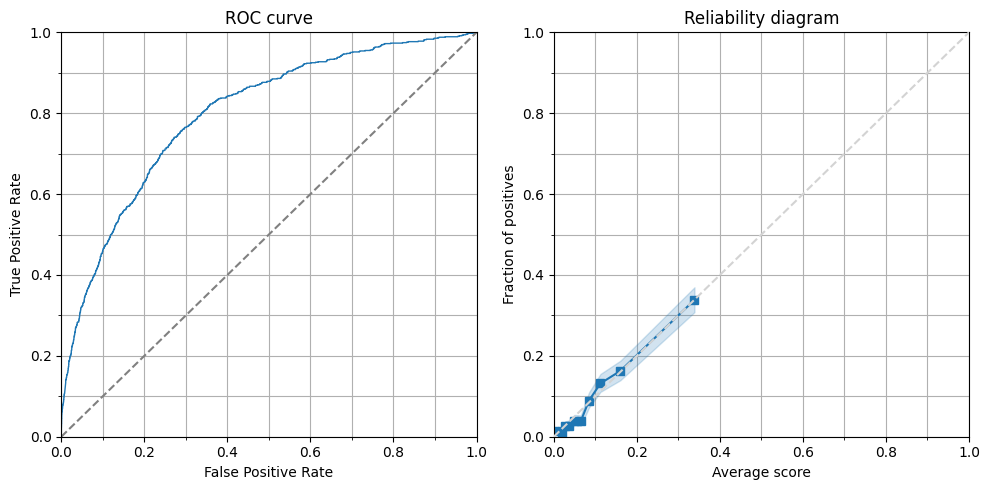

Brier score: 0.0688
AUROC: 0.7991


In [11]:
metrics = model.validate(dataset, partitions=test_partitions, plot=True)
print(f"Brier score: {metrics['brier']:.4f}")
print(f"AUROC: {metrics['roc']:.4f}")

Looking at the metrics and diagrams, we see that the models have definately trained pretty good. With more data, more complex models and more complex features we could do better though.

Lets look at a visualization to confirm that the model predicts intuitive xG values.

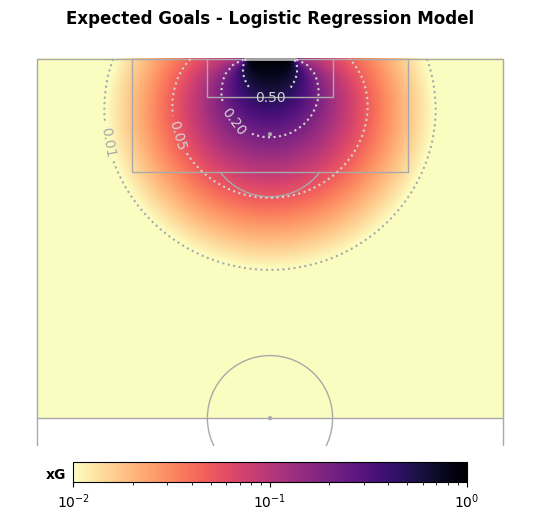

In [12]:
import itertools

import matplotlib as mpl
from matplotlib.colors import LogNorm
from mplsoccer.pitch import Pitch, VerticalPitch

import socceraction.features as fs
from socceraction import spadl

# Simulate shots from open play by foot from each location
start = np.array(list(itertools.product(np.arange(53, 106, 1), np.arange(0, 69, 1))))
df = pd.DataFrame({
    'start_x': start[:,0], 
    'start_y': start[:,1], 
    'bodypart_name': 'foot', 
    'type_name': 'shot',
    'type_id': spadl.config.actiontypes.index('shot'),
    'bodypart_id': spadl.config.bodyparts.index('foot')
})
# Compute features for these shots
df = pd.concat([
    fs.actiontype(df, [True] * len(df)), 
    fs.shot_location(df, [True] * len(df)), 
    fs.shot_dist(df, [True] * len(df)), 
    fs.shot_visible_angle(df, [True] * len(df)),
    fs.bodypart(df, [True] * len(df)),
], axis=1)

# Estimate xG value
prob_goal = model.estimate(df)['xG'].values.reshape(53, 69)

# Overwrite rcParams
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Plot pitch
pitch = VerticalPitch(
    half=True, 
    pitch_color='white', 
    line_color="darkgrey", 
    linewidth=1, 
    stripe=False,
    pitch_type='custom',
    pitch_length=105, 
    pitch_width=68
)
fig, ax = pitch.draw()
fig.set_size_inches(5.5, 5.5)

# Add xG maps and contours
pos1 = ax.imshow(prob_goal, extent = (68,0,105,52.5), aspect='equal', cmap=plt.cm.magma_r, norm=LogNorm(vmin=0.01, vmax=1), interpolation='bicubic')
cs1 = ax.contour(prob_goal, extent = (68,0,52.5,105), levels = [0.01,0.05,0.2,0.5], colors = ['darkgrey','lightgrey','lightgrey', 'lightgrey'], linestyles = 'dotted')
ax.clabel(cs1)

# Title
plt.title("Expected Goals - Logistic Regression Model", fontsize=12, color="black", fontweight="bold")

# Colourbar
cbar = fig.colorbar(pos1, ax=ax, location="bottom",  fraction = 0.04, pad = 0.0335)
cbar.ax.set_ylabel('xG', loc="bottom", color = "black", fontweight="bold", rotation=0, labelpad=20)

# Format and show
plt.show()

## Computing xG values

Once trained and validated, the model can be used to compute xG values. For example, the cell below computes the xG values of all shots in the 15/16 Premier League season.

In [13]:
xg_eng_1516 = model.estimate(dataset, partitions=test_partitions)
xg_eng_1516.head()

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:42<00:00,  8.91it/s]


xG
game_id action_id original_event_id                             
3879863 260       2a3e2865-60e6-4cb2-a06b-f9f0ef12cf1a  0.103603
        364       73b8246f-651b-4928-a5c9-b564defc745b  0.012759
        395       aa19ffa3-92de-46b7-b278-ea9d3279f2da  0.100654
        425       466ca587-1936-4f3b-a75d-a9b26e9e09a4  0.050079
        442       395d6167-1f01-45bf-a82f-1c1fdecc5123  0.042002

These can be aggregated to compute the total xG value of each player in the 15/16 season.

In [14]:
(
    dataset.read_table("actions", partitions=test_partitions)
    .join(xg_eng_1516, on=["game_id", "action_id", "original_event_id"], how="right")
    # sum xG values for each player
    .groupby(['team_id', 'player_id'])[['xG']].sum()
    # find player name
    .merge(dataset.players(), on=['team_id', 'player_id'], how="left")
    .merge(dataset.teams(), on=['team_id'], how="left")
    # get top 10
    .sort_values(by='xG', ascending=False)
    .head(n=10)
)

Reading partition PartitionIdentifier(competition_id=12, season_id=27, game_id=None) of actions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:15<00:00, 24.29it/s]


,team_id,player_id,xG,player_name,team_name
50,227,5497.0,21.631824,Gonzalo Gerardo Higuaín,Napoli
290,239,7033.0,14.246286,Nikola Kalinić,Fiorentina
355,243,5688.0,12.844748,Carlos Arturo Bacca Ahumada,AC Milan
131,230,8272.0,12.461254,Cyril Théréau,Udinese
101,229,6973.0,12.156647,Edin Džeko,AS Roma
203,233,8180.0,10.586204,Leonardo Pavoletti,Genoa
270,238,6987.0,10.117196,Mauro Emanuel Icardi Rivero,Inter Milan
339,241,7471.0,9.619854,Andrea Belotti,Torino
4,224,5472.0,9.241290,Mario Mandžukić,Juventus
26,226,6686.0,9.174782,Giampaolo Pazzini,Hellas Verona


## Default models

Instead of building your own xG model, you can also use one of the default models that are included in socceraction.

In [28]:
from socceraction.xg import (
    # An xG model for penalties
    PenaltyXGModel, 
    # An xG model for direct free kicks
    FreekickXGModel, 
    # An xG model for open play shots using basic features
    BasicOpenplayXGModel, 
    # An xG model for open play shots using more advanced features
    AdvancedOpenplayXGModel,
    # An xG model for open play shots using more advanced features
    # only available in StatsBomb data (e.g., goalkeeper position,
    # positions of defenders, etc.)
    StatsBombOpenplayXGModel,
)

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:26<00:00, 14.19it/s]


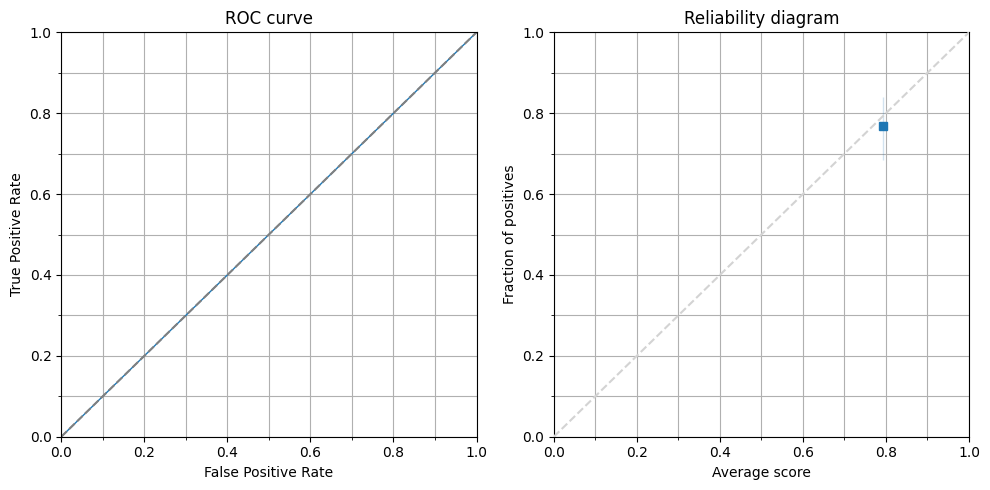

{'max_dev': nan, 'residual_area': nan, 'roc': 0.5, 'brier': 0.17842590596933058, 'ece': 0.023857958677685923, 'ace': 0.023857958677685923}


In [29]:
penaltymodel = PenaltyXGModel()
#penaltymodel.train(dataset, partitions=train_partitions)
metrics = penaltymodel.validate(dataset, partitions=test_partitions)
print(metrics)

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:35<00:00, 10.81it/s]


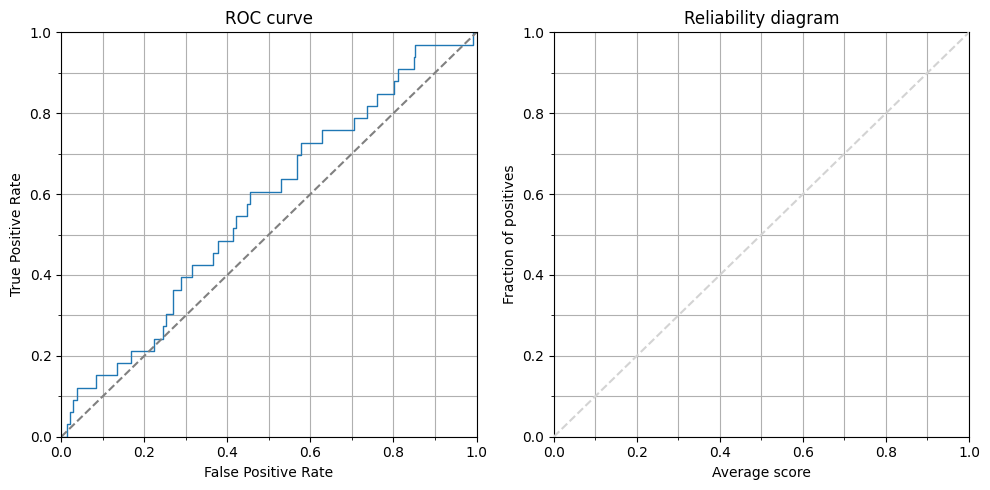

{'max_dev': 0.054662204827815475, 'residual_area': 0.001714559824251342, 'roc': 0.5697105584997961, 'brier': 0.06398738671777895, 'ece': 0.00927688784019087, 'ace': 0.025438146696397816}


In [30]:
freekickmodel = FreekickXGModel()
freekickmodel.train(dataset, partitions=train_partitions)
metrics = freekickmodel.validate(dataset, partitions=test_partitions)
print(metrics)

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:40<00:00,  9.30it/s]


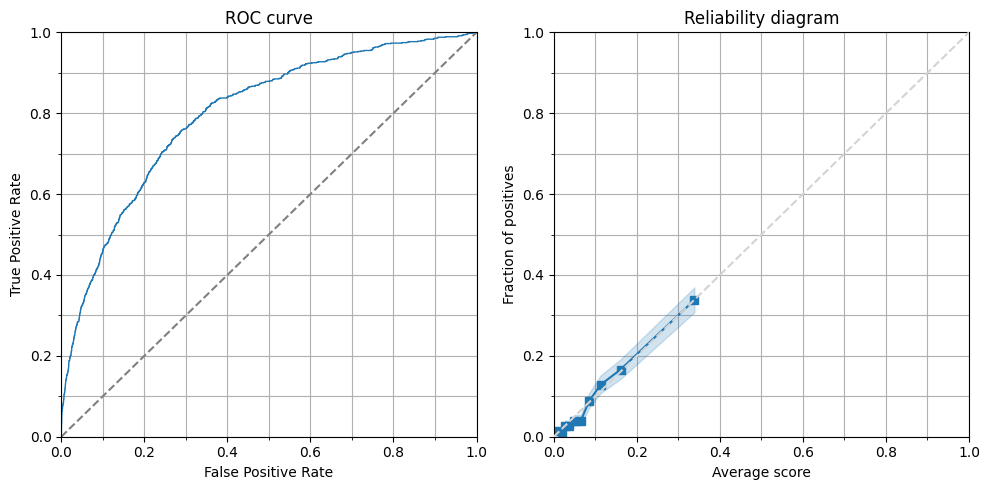

{'max_dev': 0.025847596258441387, 'residual_area': 0.002162822212453407, 'roc': 0.7988094404914654, 'brier': 0.06884968599497708, 'ece': 0.008796641571129388, 'ace': 0.008889773205027967}


In [31]:
openplaymodel = BasicOpenplayXGModel()
openplaymodel.train(dataset, partitions=train_partitions)
metrics = openplaymodel.validate(dataset, partitions=test_partitions)
print(metrics)

## Composing models

The models that we've trained above all predict the xG of a specific type of shots. To be able to compute xG values from all shot types, you will have to combine them. This can be done by wrapping them in a `XGModelEnsemble`.

In [32]:
from socceraction.xg import XGModelEnsemble

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:26<00:00, 14.29it/s]


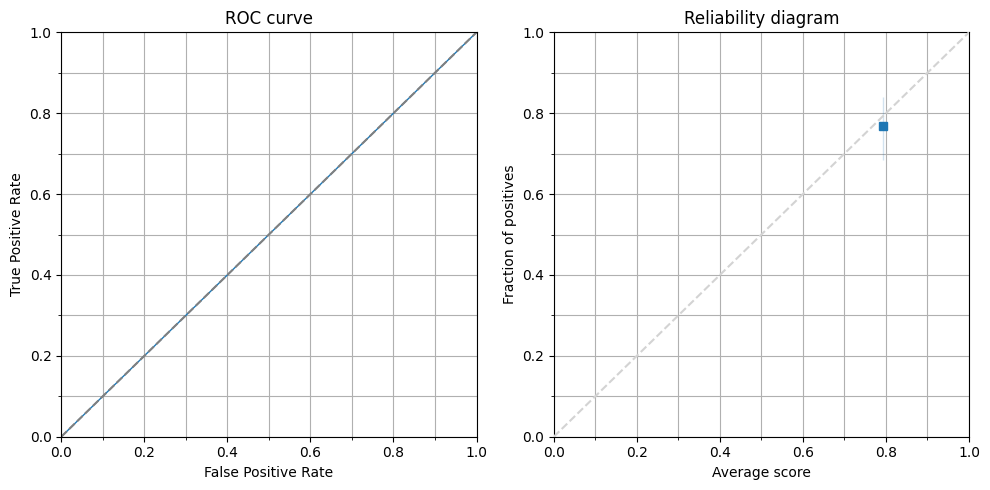

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:35<00:00, 10.70it/s]


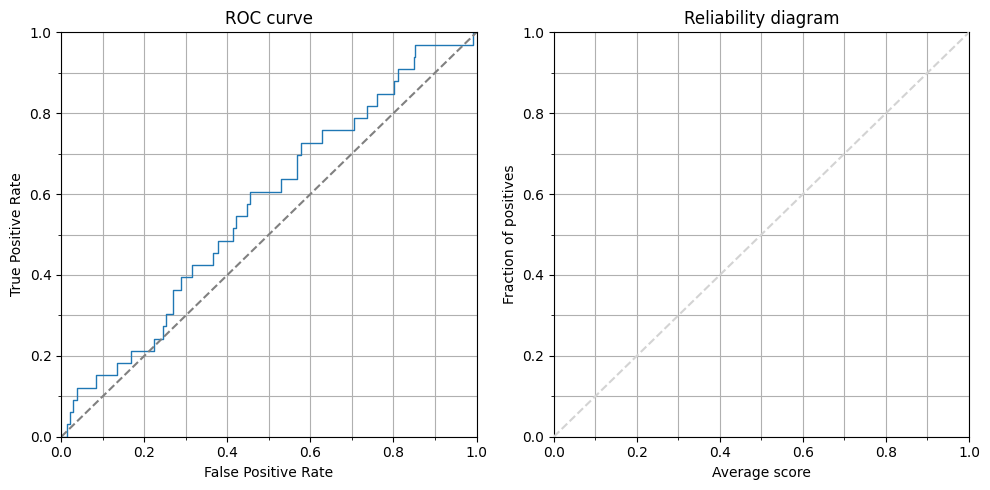

Transforming dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:41<00:00,  9.27it/s]


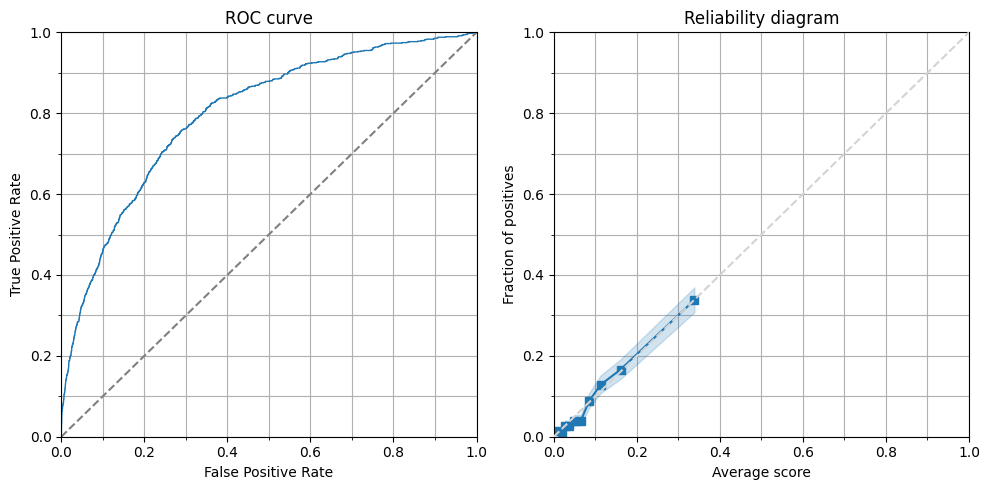

{'max_dev': 0.025847596258441387, 'residual_area': 0.002162822212453407, 'roc': 0.7988094404914654, 'brier': 0.06884968599497708, 'ece': 0.008796641571129388, 'ace': 0.008889773205027967}


In [34]:
composed_model = XGModelEnsemble(models=[penaltymodel, freekickmodel, openplaymodel])
composed_model.train(dataset, partitions=train_partitions)
metrics = composed_model.validate(dataset, partitions=test_partitions)
print(metrics)